In [9]:
#workshop: diffusion
import numpy as np
import matplotlib.pyplot as plt
import sys

In [4]:
#---function to solve a tridiagnonal matrix equation----
def tridiag(a, b, c, d): # [abc]x=d; a:num, b,c:num-1, d:num
    num=len(d)
    for k in range(1,num): #forward elimination
        m=a[k-1]/b[k-1]
        b[k]=b[k]-m*c[k-1]
        d[k]=d[k]-m*d[k-1]
    #backward substitution
    res = np.zeros(num)
    res[num-1]=d[num-1]/b[num-1]
    for k in range(num-2,-1,-1):
        res[k]=(d[k]-c[k]*res[k+1])/b[k]
    return res

In [7]:
def initialize_f(x):
    n = np.size(x)
    f = np.exp(-(x-0.3)**2/0.05**2) # set up initial function
    for i in range(n):
        if (f[i]<1.e-10):
            f[i] = 1.e-10
        if (x[i]>0.6 and x[i]<0.8):
            f[i] = 1.0
    return f

In [43]:
def evolve_diffusion(f, D, dt, dx, cfl, tend, BC = 'outflow', method = 'implicit'):
    time = 0.0
    n = np.size(f)
    fnew = 0*f #make a copy in new array
    while (time < tend):
        dt = min(dt, tend-time)
        Lam = D*dt/(dx*dx)
        time = time+dt
        if (method == 'FTCS'):
            for i in range(n):
                if (i != 0 and i != n-1):
                    fnew[i] = f[i] + Lam*(f[i+1]-2*f[i]+f[i-1])
                if (BC == 'outflow'):
                    if (i == 0):
                        fnew[i] = f[i] + Lam*(f[i+1]-2*f[i]+f[0]) #copy variable in GZ (outflow)
                    if (i == n-1):
                        fnew[i] = f[i] + Lam*(f[n-1]-2*f[i]+f[i-1]) #copy variable in GZ
                elif (BC == 'periodic'):
                    if (i == 0):
                        fnew[i] = f[i] + Lam*(f[i+1]-2*f[i]+f[n-1]) #copy variable in GZ (outflow)
                    if (i == n-1):
                        fnew[i] = f[i] + Lam*(f[0]-2*f[i]+f[i-1]) #copy variable in GZ
            f = 1*fnew
        elif (method == 'implicit'):
            if (BC == 'outflow'):
                aa, bb, cc, dd = -Lam*np.ones(n+1), 1.0 + 2.*Lam*np.ones(n+2), -Lam*np.ones(n+1), np.zeros(n+2)
                dd[1:n+1], aa[n], cc[0], bb[0], bb[n+1], dd[0], dd[n+1] = 1.*f, -1, -1, 1, 1, 0, 0 #subtlety w. indices
                fnew = tridiag(aa, bb, cc, dd)
                f = fnew[1:n+1]
            elif (BC == 'periodic'): #since periodic problem is not tridiagonal, we use Sherman-Morrison formula in section 2.7.1 of Numerical Recipes Third Edition
                aa, bb, cc, dd = -Lam*np.ones(n-1), 1.0 + 2.*Lam*np.ones(n), -Lam*np.ones(n-1), 1.*f
                bb[0], bb[n-1] = bb[0] - 1, bb[n-1] - Lam*Lam
                u, v = np.zeros(n), np.zeros(n)
                u[0], v[0], u[n-1], v[n-1] = 1, 1, -Lam, -Lam
                z = tridiag(np.copy(aa), np.copy(bb), np.copy(cc), u) #need a copy since arrays are changed in the function
                y = tridiag(aa, bb, cc, dd)
                f = y - z*np.dot(v,y)/(1 + np.dot(v,z))
            else:
                print("Illegal boundary condition")
                sys.exit()
        elif (method == 'crank-nicholson'):
            if (BC == 'outflow'):
                aa, bb, cc, dd = -0.5*Lam*np.ones(n+1), 1.0 + Lam*np.ones(n+2), -0.5*Lam*np.ones(n+1), np.zeros(n+2)
                aa[n], cc[0], bb[0], bb[n+1] = -1 , -1, 1, 1#subtlety w. indices
                for i in range(1,n+1): #be careful about boundaries; outflow BCs implemented via im2 and ii
                    if (i == 1):
                        im2 = i-1
                    else:
                        im2 = i-2
                    if (i == n):
                        ii = i-1
                    else:
                        ii = i
                    dd[i] = f[i-1] + 0.5*Lam*(f[ii]-2*f[i-1]+f[im2])
                fnew = tridiag(aa,bb,cc,dd)
                f=fnew[1:n+1]
            elif (BC == 'periodic'):
                aa, bb, cc, dd = -0.5*Lam*np.ones(n-1), 1.0 + Lam*np.ones(n), -0.5*Lam*np.ones(n-1), np.zeros(n)
                bb[0], bb[n-1] = bb[0] - 1, bb[n-1] - 0.25*Lam*Lam
                u, v = np.zeros(n), np.zeros(n)
                u[0], v[0], u[n-1], v[n-1] = 1, 1, -0.5*Lam, -0.5*Lam
                z = tridiag(np.copy(aa), np.copy(bb), np.copy(cc), u) #need a copy since arrays are changed in the function
                for i in range(n):
                    if (i == 0):
                        im1, ip1 = n-1, i+1
                    elif (i == n-1):
                        im1, ip1 = i-1, 0
                    else:
                        im1, ip1 = i-1, i+1
                    dd[i] = f[i] + 0.5*Lam*(f[im1]-2*f[i]+f[ip1])
                y = tridiag(aa, bb, cc, dd)
                f = y - z*np.dot(v,y)/(1 + np.dot(v,z))
            else:
                print("Illegal boundary condition")
                sys.exit()
        else:
            print("Illegal option for method")
            sys.exit()
    return f

0.2839351925767914
0.2839351925767857


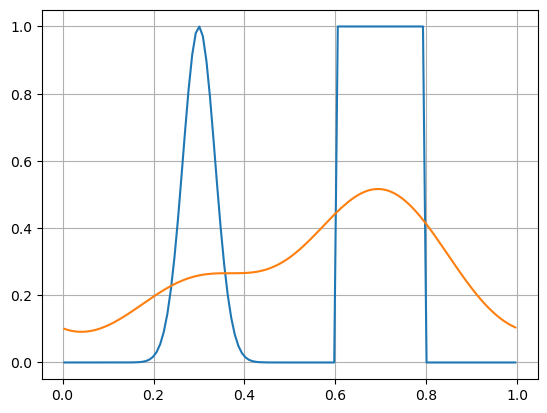

In [49]:
#setting up initial condition, # of grid points, etc.
n = 128 # number of grid points
dx = 1.0/n #grid spacing
x = np.arange(0.0, 1.0, dx)
x = x + 0.5*dx #cell-centered grid; be careful abt grid centering
f = initialize_f(x)
plt.plot(x, f ,'-')
print (np.mean(f)) #mean(f) should remain the same if there is no net flux entering/leaving the box
D = 1.0
cfl = 10 #CFL number
dt = cfl*dx*dx/(2.*D) #timestep
tend=0.01
f = evolve_diffusion(f, D, dt, dx, cfl, tend, BC = 'periodic', method = 'crank-nicholson')
plt.plot(x, f ,'-')
plt.grid()
print(np.mean(f))